In [1]:
import os
import mmcv
import torch
import cv2 as cv
import numpy as np 
from torch import optim
from PIL import Image, ImageDraw
from IPython import display
from IPython.display import Video
from keras_facenet import FaceNet
import matplotlib.pyplot as plt
from mtcnn.mtcnn import MTCNN
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import MultiStepLR
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader, SubsetRandomSampler
from facenet_pytorch import MTCNN, InceptionResnetV1, fixed_image_standardization, training

In [2]:
class FACELOADING:
    def __init__(self, directory):
        self.directory = directory
        self.target_size = (160,160)
        self.X = []
        self.Y = []
        self.detector = MTCNN()
    

    def extract_face(self, filename):
        img = cv.imread(filename)
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        x,y,w,h = self.detector.detect_faces(img)[0]['box']
        x,y = abs(x), abs(y)
        face = img[y:y+h, x:x+w]
        face_arr = cv.resize(face, self.target_size)
        return face_arr
    

    def load_faces(self, dir):
        FACES = []
        for im_name in os.listdir(dir):
            try:
                path = dir + im_name
                single_face = self.extract_face(path)
                FACES.append(single_face)
            except Exception as e:
                pass
        return FACES

    def load_classes(self):
        for sub_dir in os.listdir(self.directory):
            path = self.directory +'/'+ sub_dir+'/'
            FACES = self.load_faces(path)
            labels = [sub_dir for _ in range(len(FACES))]
            print(f"Loaded successfully: {len(labels)}")
            self.X.extend(FACES)
            self.Y.extend(labels)
        
        return np.asarray(self.X), np.asarray(self.Y)


    def plot_images(self):
        plt.figure(figsize=(18,16))
        for num,image in enumerate(self.X):
            ncols = 3
            nrows = len(self.Y)//ncols + 1
            plt.subplot(nrows,ncols,num+1)
            plt.imshow(image)
            plt.axis('off')

In [3]:
faceloading = FACELOADING("dataset")
X, Y = faceloading.load_classes()

1/1 [==============================] - 0s 16ms/step
Loaded successfully: 25
1/1 [==============================] - 0s 22ms/step
Loaded successfully: 13
2/2 [==============================] - 0s 14ms/step
Loaded successfully: 25
1/1 [==============================] - 0s 16ms/step
Loaded successfully: 9
1/1 [==============================] - 0s 16ms/step
Loaded successfully: 17
1/1 [==============================] - 0s 16ms/step
Loaded successfully: 10
1/1 [==============================] - 0s 20ms/step
Loaded successfully: 25


In [ ]:
plt.figure(figsize=(16,12))
for num,image in enumerate(X):
    ncols = 6
    nrows = len(Y)//ncols + 1
    plt.subplot(nrows,ncols,num+1)
    plt.imshow(image)
    plt.axis('off')

In [5]:
from keras_facenet import FaceNet
embedder = FaceNet()

def get_embedding(face_img):
    face_img = face_img.astype('float32') # 3D(160x160x3)
    face_img = np.expand_dims(face_img, axis=0) 
    # 4D (Nonex160x160x3)
    yhat= embedder.embeddings(face_img)
    return yhat[0] # 512D image (1x1x512)
EMBEDDED_X = []

for img in X:
    EMBEDDED_X.append(get_embedding(img))

EMBEDDED_X = np.asarray(EMBEDDED_X)

1/1 [==============================] - 0s 32ms/step


Text(0, 0.5, '0')

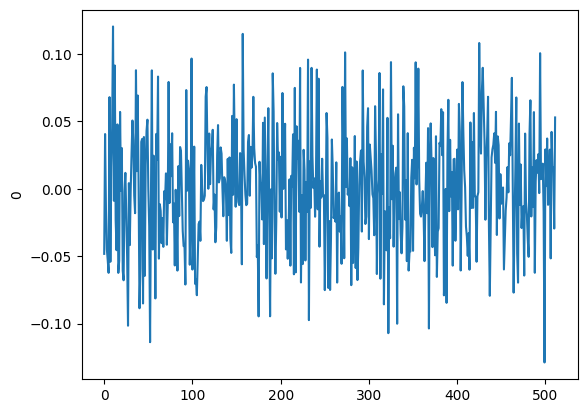

In [6]:
from sklearn.preprocessing import LabelEncoder
np.savez_compressed('faces_embeddings_v1.npz', EMBEDDED_X, Y)
encoder = LabelEncoder()
encoder.fit(Y)
Y = encoder.transform(Y)
plt.plot(EMBEDDED_X[0]) 
plt.ylabel(Y[0])

In [7]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(EMBEDDED_X, Y, shuffle=True, random_state=17)
model = SVC(kernel='linear', probability=True)
model.fit(X_train, Y_train)
ypreds_train = model.predict(X_train)
ypreds_test = model.predict(X_test)
from sklearn.metrics import accuracy_score

accuracy_score(Y_train, ypreds_train),accuracy_score(Y_test,ypreds_test)

(1.0, 1.0)

In [8]:
# t_im = cv.imread(r"C:\Users\sahil\OneDrive\Pictures\Camera Roll\WIN_20230805_02_02_06_Pro.jpg")
# t_im = cv.cvtColor(t_im, cv.COLOR_BGR2RGB)
# x,y,w,h = detector.detect_faces(t_im)[0]['box']
# t_im = t_im[y:y+h, x:x+w]
# t_im = cv.resize(t_im, (160,160))
# test_im = get_embedding(t_im)
# test_im = [test_im]
# ypreds = model.predict(test_im)
# ypreds
# encoder.inverse_transform(ypreds)
##for static image  

In [9]:
import pickle
with open('svm_model_160x160.pkl','wb') as f:
    pickle.dump(model,f)
# import torch
# model1 = torch.hub.load('ultralytics/yolov5', 'yolov5s')
# cv.imshow('YOLO', np.squeeze(results.render()))      

In [3]:
import cv2 as cv
import numpy as np
import os

os.environ['TF_CPP_MIN_LOG_LEVEL']='2'
from sklearn.preprocessing import LabelEncoder
import pickle
from keras_facenet import FaceNet

#INITIALIZE
facenet = FaceNet()
faces_embeddings = np.load("faces_embeddings_v1.npz")
Y = faces_embeddings['arr_1']
encoder = LabelEncoder()
encoder.fit(Y)
haarcascade = cv.CascadeClassifier("face.xml")
model = pickle.load(open("svm_model_160x160.pkl", 'rb'))




cap = cv.VideoCapture(1)

while cap.isOpened():
    _, frame = cap.read()
    frame = cv.flip(frame,flipCode=1)
    rgb_img = cv.cvtColor(frame, cv.COLOR_BGR2RGB)
    gray_img = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
    faces = haarcascade.detectMultiScale(gray_img, 1.3, 5)


    for x,y,w,h in faces:
        
        img = rgb_img[y:y+h, x:x+w]
        img = cv.resize(img, (160,160)) # 1x160x160x3
        img = np.expand_dims(img,axis=0)
        ypred = facenet.embeddings(img)
        face_name = model.predict(ypred)
        final_name = encoder.inverse_transform(face_name)[0]
        cv.rectangle(frame, (x,y), (x+w,y+h), (0,0,255), 1)
        cv.putText(frame, str(final_name), (x,y-10), cv.FONT_HERSHEY_SIMPLEX,
                   1, (0,0,255), 3, cv.LINE_AA)
  
    cv.imshow("Face Recognition:", frame)
    if cv.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv.destroyAllWindows()

1/1 [==============================] - 0s 43ms/step
